<a href="https://colab.research.google.com/github/yeshavyas27/ai_usecases_generation_multiagent/blob/main/Multi_agent_for_AI_usecases_generation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [4]:
!conda install tavily-python langgraph langgraph-checkpoint-sqlite langchain_mistralai
!conda install pygraphviz

Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ | / failed

PackagesNotFoundError: The following packages are not available from current channels:

  - tavily-python
  - langgraph-checkpoint-sqlite
  - langchain_mistralai

Current channels:

  - https://conda.anaconda.org/conda-forge

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.


Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [5]:
from google.colab import userdata
import os

os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
os.environ["MISTRAL_API_KEY"] = userdata.get('MISTRAL_API_KEY')

In [6]:
from tavily import TavilyClient
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [7]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langgraph.checkpoint.memory import MemorySaver
import sqlite3

# memory = SqliteSaver.from_conn_string(":memory:")
db_path = 'checkpoints.db'
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)


In [8]:
from pydantic import BaseModel, Field

class Queries(BaseModel):
  queries: List[str]


class Sources(BaseModel):
  data: str
  url: str
  id: int


class CitedUseCase(BaseModel):
    answer: str = Field(
        ...,
        description="All the data of a usecase, which is based only on the given sources.",
    )
    citations: List[int] = Field(
        ...,
        description="The integer IDs of the SPECIFIC sources which justify the usecase.",
    )

class CitedUseCaseWithAssets(CitedUseCase):
    assets: List[str]

class UseCases(BaseModel):
    usecases: List[CitedUseCase]

In [9]:
class AgentState(TypedDict):
    input_company_industry: str
    assets: List[str]
    draft: str
    content: List[Sources]
    source_id_start: int


In [10]:
from langchain_mistralai import ChatMistralAI

model = ChatMistralAI(
    model="mistral-small-latest",
    temperature=0,
)

In [50]:
RESEARCH_INDUSTRY_PROMPT = """
You are an expert at identifying relevant industries given a company name or industry name.
Generate a list of search queries that will gather key focus areas for the company or industry (e.g., operations, supply chain, customer experience, etc.)
Different products related to the industry or company should also be included.
Generate a list of search queries that will gather any relevant information.
Only generate 3 queries max.

"""

RESEARCH_AI_USECASES_PROMPT = """
You are an expert in finding loopholes in various industries which can be resolved by Artificial Intelligence (AI), Machine Learning (ML) and Automation.
Refer to reports and insights on AI and digital transformation from industry-specific sources to find potential solutions.
It could improve efficiency, solve problems and innvoate. Generate a list of search queries that will gather any relevant information given the data. A
Only generate 5 queries max.

"""

WRITER_PROMPT = """
You are an AI expert who can identify areas usecases of Artificial Intelligence (AI), Machine Learning (ML) and Automation in a given company/industry.
You are given data on possible usecases in a specific industry. Identify the best top 3 usecases and provide details for each including the problem and it's solution using AI, ML or automation. Do not explicitly use the word problem and solution. Write a paragraph for each usecase.
"""

RESEARCH_DATASETS_FOR_USECASES_PROMPT = """
You are an expert at searching relevant datasets/ databases or relevant projects for a solving problem or usecase, which can be used for AI, ML and automation.
Generate a list of search queries that will gather any relevant information to this.
Only generate 3 queries max.
"""

In [51]:
def research_and_identify_industry_node(state: AgentState):
  queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_INDUSTRY_PROMPT),
        HumanMessage(content=f"Here is the company/industry: {state['input_company_industry']}.")
        ])
  content =  state.get('content', [])
  source_id_start = state['source_id_start']
  for q in queries.queries:
      response = tavily.search(query=q, max_results=2)
      for r in response['results']:
        source_id_start = source_id_start + 1
        content.append(Sources(data=r['content'], url=r['url'], id=source_id_start))

  return {"content": content}

def research_relevant_ai_usecases_node(state: AgentState):
  queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_AI_USECASES_PROMPT),
        HumanMessage(content=f"Here is company/industry: {state['input_company_industry']}. Some relevant data to the industry: {' '.join([source.data for source in state['content']])}")
        ])
  content = state['content']
  source_id_start = content[-1].id
  for q in queries.queries:
      response = tavily.search(query=q, max_results=2)
      for r in response['results']:
        source_id_start = source_id_start + 1
        content.append(Sources(data=r['content'], url=r['url'], id=source_id_start))

  return {"content": content}

def generate_draft_node(state: AgentState):
  usecases = model.with_structured_output(UseCases).invoke([
        SystemMessage(content=WRITER_PROMPT),
        HumanMessage(content=f"Here is company/industry: {state['input_company_industry']}. Some relevant data to the industry and possible usecases: {' '.join([f' Source: {source.id} Information:{source.data} ' for source in state['content']])}")
        ])
  return {"draft": usecases}

def research_assets_for_usecases_node(state: AgentState):
  # loop through the list and find relevant datasets
  content = state['content']
  draft = state['draft']

  usecases_with_assets = []
  for usecase in draft.usecases:
    queries = model.with_structured_output(Queries).invoke([
          SystemMessage(content=RESEARCH_DATASETS_FOR_USECASES_PROMPT),
          HumanMessage(content=f"The problem domain or usecase that I am trying to solve for is {usecase.answer}")
          ])
    urls = []

    for q in queries.queries:
        response = tavily.search(query=q, max_results=2, include_domains=["kaggle.com/datasets", "huggingface.co/datasets", "github.com"])
        for r in response['results']:
          urls.append(r['url'])
    usecases_with_assets.append(
        CitedUseCaseWithAssets(
            answer=usecase.answer,
            citations=usecase.citations,
            assets=urls
        )
    )

  return {"draft": usecases_with_assets}




In [52]:
builder = StateGraph(AgentState)
builder.add_node("research_industry", research_and_identify_industry_node)
builder.add_node("research_ai_usecases", research_relevant_ai_usecases_node)
builder.add_node("generate_draft", generate_draft_node)
builder.add_node("research_assets", research_assets_for_usecases_node)


In [53]:
builder.set_entry_point("research_industry")

In [54]:
builder.add_edge("research_industry", "research_ai_usecases")
builder.add_edge("research_ai_usecases", "generate_draft")
builder.add_edge( "generate_draft", "research_assets")
builder.add_edge( "research_assets", END)




In [58]:
user_input = "Myntra"
config = {"configurable": {"thread_id": "6"}}
graph = builder.compile(checkpointer=memory)
for s in graph.stream({
      'input_company_industry': user_input,
      "source_id_start": 0

  }, config):
      print(s)


{'research_industry': {'content': [Sources(data='By addressing these areas of improvement, Myntra can continue to improve its supply chain operations and deliver a better customer experience. #myntra#myntralogistics#supplychain#logistics#', url='https://www.linkedin.com/pulse/supply-chain-efficiencies-areas-improvement-myntra-devendra-rachelkar', id=1), Sources(data='Disruptions in the supply chain, whether due to external factors or internal inefficiencies, can adversely affect product availability and customer satisfaction. 4. Limited Physical Presence: Unlike some competitors adopting an omnichannel approach with physical stores complementing their online platforms, Myntra primarily operates online.', url='https://www.businessscroller.com/myntra-swot-analysis/', id=2), Sources(data='Description: This dataset contains information about various fashion products available on Myntra. It includes details such as product names, categories, prices, ratings, and reviews. Use: We used this d

In [59]:


content = graph.get_state(config).values["content"]

for usecases in s["research_assets"]["draft"]:
  print(f"\n\n {usecases.answer}\n")
  print(f" References links: \n {' , '.join([content[citation_id].url for citation_id in usecases.citations])}\n")
  print(f"Assets / Datasets links for the usecase: \n{' , '.join(usecases.assets)} \n")
  print('=' * 500)




 Improving Supply Chain Operations: Myntra can leverage AI and machine learning to optimize its supply chain operations. By analyzing historical data and real-time information, predictive analytics can forecast demand more accurately, ensuring that popular items are always in stock. Additionally, AI-driven logistics management can streamline inventory management, reduce lead times, and enhance overall efficiency. This approach can help in maintaining product availability and improving customer satisfaction by minimizing disruptions caused by external factors or internal inefficiencies.

 References links: 
 https://www.businessscroller.com/myntra-swot-analysis/ , https://github.com/bhanu-sri/Myntra_Fashion_Trends-Analysis

Assets / Datasets links for the usecase: 
https://github.com/bhshivani/Ecommerce-supply-chain-analysis , https://github.com/microsoft/OptiGuide , https://github.com/tushar2704/Store-Demand-Forecasting , https://huggingface.co/datasets/infinite-dataset-hub/RetailSal

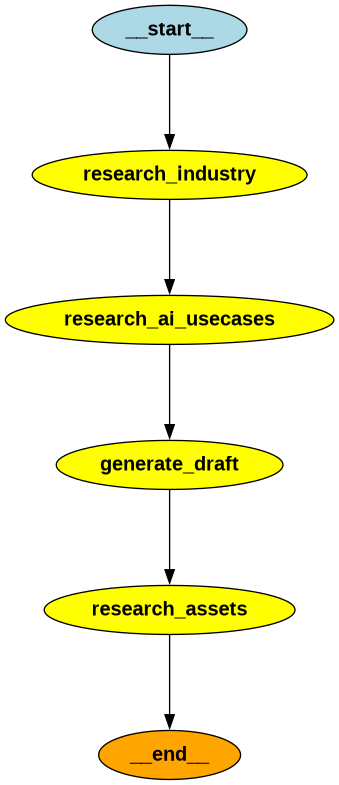

In [57]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph().draw_png()
    )
)